**<H1> TOPIC MODELING ON SHORT TEXT DATA </H>**


**PROJECT BY : NIDHI GOWRI SRINATH (801199302)**


This project is intended to identify important topics from short text data using techniques of Natural Language Processing namely Latent Dirichlet Allocation (LDA) and Non-negative matrix factorization (NMF). The papers that have been used as reference can be found [here](https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full) and [here.](https://arxiv.org/abs/1711.04305)

This project uses a Kaggle dataset containing news headlines from Australian Broadcasting Corporation. The dataset can be found [here.](https://www.kaggle.com/datasets/therohk/million-headlines)

The reference notebooks used for this project can be found below:
- [Reference 1](https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920)
- [Reference 2](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

Documentations for the additional libraries used have been linked in the markdowns. 

In [1]:
# Importing the necessary packages
import re
import numpy as np
import pandas as  pd
from pprint import pprint
# Importing the Gensim package
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel 
# Importing SpaCy
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
# Importing NLTK
import nltk
nltk.download('stopwords')
# Importing wordcloud
from wordcloud import WordCloud
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore", category= DeprecationWarning)

/Users/nidhisrinath/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nidhisrinath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing the NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
# Importing the dataset and initializing it to contain 50% of the dataset
df = pd.read_csv('abcnews-date-text.csv')
df.drop('publish_date', axis=1,inplace=True)
print(len(df))
df['index'] = df.index
df.head()

1244184


,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


In [4]:
# Reducing the dataset by 10% to ensure that the model does not take too long to execute
count = int((len(df)*0.10))
df = df.head(n=count)
print(len(df))
df.head()

124418


,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


### Data Preprocessing

We must now convert the data into a form that helps us convert each headline into tokens and remove the stop words that reduce the efficiency of our model. For this preprocessing, we will be using gensims simple_preprocess. The documentation for this can be found [here.](https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html)

In [5]:
# Converting the headlines to a list 
data = df[['headline_text','index']].values.tolist()
data[:10]

[['aba decides against community broadcasting licence', 0],
 ['act fire witnesses must be aware of defamation', 1],
 ['a g calls for infrastructure protection summit', 2],
 ['air nz staff in aust strike for pay rise', 3],
 ['air nz strike to affect australian travellers', 4],
 ['ambitious olsson wins triple jump', 5],
 ['antic delighted with record breaking barca', 6],
 ['aussie qualifier stosur wastes four memphis match', 7],
 ['aust addresses un security council over iraq', 8],
 ['australia is locked into war timetable opp', 9]]

In [6]:
# Using a function to preprocess each sentence in the
def sentence_to_words(sentences):
    for sentence in sentences:
        # The yield() function returns the values with time rather than all at once like the return() function
        # We use yeild() to ensure that the code does not take too long to execute as we are working with a big dataset
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        # deacc = True is used to remove any kind of punctuations in the data
data_words = list(sentence_to_words(data))
print(data_words[:1])

[['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']]


After converting the sentences to words , the data needs to be analysed for Bigrams and Trigrams. 
Bigrams are 2 words that occur together frequently in our document. Trigrams are 3 frequently occuring words.
The phrases function takes two arguments, threshold and min_count. 
- Threshold - Threshold represents a score for forming phrases in our data. Higher the threshold value, lower the number of phrases
- Min count - Ignores all words and bigrams with total count lower than this value.


The documentation can be found [here.](https://radimrehurek.com/gensim/models/phrases.html)

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Looking at the bigram and trigram model example on one of our headlines
print(trigram_mod[bigram_mod[data_words[0]]])

['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']


We will now be removing the stop words from our dataset, finding bigrams and trigrams, and performing lemmatization. 
Lemmatization is the process that groups words of different forms together. 

In [8]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Removing the stop words
data_words_nostops = remove_stopwords(data_words)

# Forming bigrams with our words
data_words_bigrams = make_bigrams(data_words_nostops)

# initializing the spaCy 'en' model
# We disable the parser which assigns dependency labels
# We disable 'ner' which detects document labels  
# !python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['decide', 'community', 'broadcast', 'licence']]


## Creating a dictionary and corpus needed for topic modelling
- The dictionary contains a list of all the unique words occurring in the corpus
- The corpus is a collection of authentic text organized   

In [10]:
# Creating a Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Creating a Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


Gensim creates unique id for each word in the document. Its mapping of word_id and word_frequency. For instance, (4,2) indicates that the word_id 4 contains a frequency of 2.

In [11]:
# Looking at the corpus the above example
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('broadcast', 1), ('community', 1), ('decide', 1), ('licence', 1)]]

## Latent Dirichlet Allocation 
Latent Dirichlet allocation (LDA) is a probabilistic generative model of a corpus. The core notion is that documents are represented as random combinations of latent topics, with each subject defined by a word distribution.
LDA uses multiple parameters, our model will be using the following :
- corpus - Contains the stream of document vectors or sparse matrix of shape.
- id2word - Mapping the word IDs to words.
- num_topics - The number of requested latent topics to be extracted from the training corpus.
- random_state - RandomState object.
- update_every - Number of documents to be iterated through for each update.
- chunksize - Number of documents to be used in each training chunk.
- passes - Number of passes through the corpus during training.
- alpha - Alpha represents the document topic density
- beta - Beta represents topic word density

The documentation of for LDA can be found [here.](https://radimrehurek.com/gensim/models/ldamodel.html)

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Looking at the topics in the LDA model

The topics from our LDA model is a combination of keywords where each keyword contributes a certain weightage to the topic. We can analyse the keywords and weightage for each topic using print_topics()

In [13]:
# Printing the keywords of the topics
# pprint ensures that the data is printed "prettily". pprint is pretty-print  
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.349*"seek" + 0.196*"continue" + 0.144*"leave" + 0.036*"interest" + '
  '0.031*"south" + 0.026*"build" + 0.016*"goal" + 0.009*"livestock" + '
  '0.000*"probe" + 0.000*"new"'),
 (1,
  '0.171*"rise" + 0.145*"home" + 0.111*"hope" + 0.090*"cut" + 0.078*"expect" + '
  '0.078*"threat" + 0.078*"big" + 0.046*"rate" + 0.027*"championship" + '
  '0.021*"plant"'),
 (2,
  '0.330*"water" + 0.131*"woe" + 0.129*"fuel" + 0.078*"focus" + 0.057*"impact" '
  '+ 0.032*"unlikely" + 0.024*"tv" + 0.015*"become" + 0.009*"summit" + '
  '0.000*"ban"'),
 (3,
  '0.376*"man" + 0.110*"go" + 0.107*"arrest" + 0.086*"qld" + 0.051*"attempt" + '
  '0.042*"central" + 0.039*"break" + 0.035*"bombing" + 0.012*"rare" + '
  '0.000*"car"'),
 (4,
  '0.179*"find" + 0.150*"death" + 0.117*"strike" + 0.105*"lose" + 0.094*"vote" '
  '+ 0.058*"pay" + 0.040*"seat" + 0.029*"river" + 0.029*"inquest" + '
  '0.028*"staff"'),
 (5,
  '0.419*"police" + 0.190*"call" + 0.083*"green" + 0.082*"offer" + '
  '0.052*"work" + 0.037*"announc

We can visualize the frequency of occurance of a term using a word cloud. Wordcloud is a library built on  Python which generates a visualization of the frequencies of words. The documentation for wordcloud can be found [here.]() 

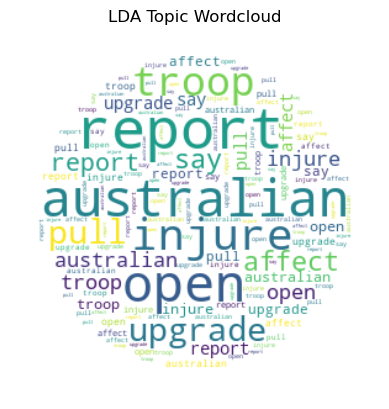

In [14]:
# Generating a wordcloud for the LDA model topics
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color='white', repeat = True, mask = mask)
for i in range(0,19):
    wc.generate(lda_model.print_topic(i))

plt.axis("off")
plt.title("LDA Topic Wordcloud")
plt.imshow(wc, interpolation="bilinear")
plt.show()

### Evaluating the topic model performance 
For our model evaluation, we will be using perplexity and coherence score 
- Perplexity - Perplexity is a measurement of how well a probability model predicts a sample.
- Coherance score - Coherance scores a single topic by measuring the degree of semantic similarity between high scoring words in the topic

The lower the perplexity the better the model performance. The higher the coherance score the better the model performance and better the readability of the data.

In [15]:
# Computing the Perplexity
print('\nPerplexity of LDA Model: ', lda_model.log_perplexity(corpus))  

# Computing the Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the LDA Model: ', coherence_lda)


Perplexity of LDA Model:  -24.933221185685447

Coherence Score of the LDA Model:  0.39780001976373197


We can see from our scores that the perplexity and coherance is -24.93 and 0.3978.

Let us now visualize the results of the LDA model.

### Visualizing the topic model
pyLDAvis is a python library for an interactive library for topic model visualization. The documentation for this library can be found [here.](https://pypi.org/project/pyLDAvis/) 

In [16]:
# Visualizing the topics.
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/nidhisrinath/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.258235 -0.345789       1        1  8.945082
5      0.169013  0.199529       2        1  8.565160
8      0.164434  0.184800       3        1  7.477735
17     0.116960  0.064818       4        1  7.110004
14     0.073475  0.027497       5        1  6.439718
15     0.028231  0.006911       6        1  6.125076
19     0.045633  0.013484       7        1  5.988286
4      0.041990  0.011989       8        1  5.941595
12    -0.019678 -0.005939       9        1  5.247493
1     -0.044817 -0.010571      10        1  5.013227
13    -0.046609 -0.010893      11        1  4.988082
6     -0.032035 -0.008326      12        1  4.868840
3     -0.025301 -0.007037      13        1  4.553799
18    -0.077179 -0.015107      14        1  4.378952
0     -0.087962 -0.016311      15        1  3.619891
11    -0.106224 -0.018036      16        1  3.087045
10    -0.095655 -0.017094      17        1  3.015990
2     -0.089864 -0.016517      18        1  2.553658
16    -0.129516 -0.019400      19        1  1.822985
7     -0.143130 -0.018007      20        1  0.257381, topic_info=          Term          Freq         Total Category  logprob  loglift
227     police  17652.000000  17652.000000  Default  30.0000  30.0000
45        plan  13224.000000  13224.000000  Default  29.0000  29.0000
264        man   8410.000000   8410.000000  Default  28.0000  28.0000
107    council   8074.000000   8074.000000  Default  27.0000  27.0000
25         win   7157.000000   7157.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
4262  aircraft      0.048945      3.388752  Topic20 -10.1594   1.7248
1394      team      0.048951      3.389185  Topic20 -10.1593   1.7248
1290     spark      0.048956      3.389605  Topic20 -10.1592   1.7248
634    release      0.048953      3.389457  Topic20 -10.1593   1.7248
438      probe      0.048954      3.390087  Topic20 -10.1592   1.7246

[814 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
235       9  0.993969   access
203      11  0.998967   accuse
4         3  0.998567      act
33        7  0.996888  address
18       14  0.995662   affect
...     ...       ...      ...
8         3  0.996175  witness
334      18  0.997865      woe
197       2  0.998733     work
342      16  0.991986    young
105       6  0.996362    youth

[213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 9, 18, 15, 16, 20, 5, 13, 2, 14, 7, 4, 19, 1, 12, 11, 3, 17, 8])

Each bubble on the left hand side of the visualization represents a topic. The bigger the bubble the more dominant the topic. We can also see that the topics are scattered around in the first two quadrants. Since the number of topics that we have chosen for our model is more, we see overlap in the topic bubbles. (lower number of topics yielded in lower model performance) Selecting each bubble will give us the topics and the keywords that are most used in the topic. As we are working with a dataset that is relevant to news, we can see that there could be more number of topics that the dataset can contain. 

Non-negative Matrix Factorization 
NMF stands for Latent Semantic Analysis with the ‘Non-negative Matrix-Factorization’ method used to decompose the document-term matrix into two smaller matrices — the document-topic matrix (U) and the topic-term matrix (W) — each populated with unnormalized probabilities.
The NMF() function takes a couple of parameters:
- Corpus - Contains the stream of document vectors or sparse matrix of shape.
- id2word - Mapping the word IDs to words.
- num_topics - Number of topics to extract
- chunksize – Number of documents to be used in each training chunk.
- passes – Number of full passes over the training corpus. 
- kappa – Gradient descent step size. 
- max_iter - Maximum iterations before timing out
- eval_every – Number of batches after which l2 norm of (v - Wh) is computed. 
- normalize – Whether to normalize the result. Allows for estimation of perplexity, coherence, e.t.c.
- random_state – Seed for random generator. Needed for reproducibility.

The documentation for NMF can be found [here.](https://radimrehurek.com/gensim/models/nmf.html)

In [30]:
nmf_model = gensim.models.nmf.Nmf(corpus=corpus,
                                num_topics = 20,
                                id2word = id2word,
                                chunksize = 100,
                                passes = 10,
                                kappa=.1,
                                normalize=True,
                                random_state=42
                                )

Looking at the topics in the NMF model

The topics from our NMF model is a combination of keywords where each keyword contributes a certain weightage to the topic. We can analyse the keywords and weightage for each topic using print_topics()

In [31]:
# Printing the keywords of the topics
# pprint ensures that the data is printed "prettily". pprint is pretty-print  
pprint(nmf_model.print_topics())
doc_nmf = nmf_model[corpus]

[(0,
  '0.283*"new" + 0.028*"back" + 0.015*"law" + 0.012*"set" + 0.010*"year" + '
  '0.009*"get" + 0.007*"name" + 0.006*"record" + 0.006*"rule" + 0.006*"deal"'),
 (1,
  '0.336*"police" + 0.030*"arrest" + 0.028*"investigate" + 0.019*"drug" + '
  '0.013*"miss" + 0.012*"name" + 0.009*"driver" + 0.008*"vic" + 0.008*"search" '
  '+ 0.008*"officer"'),
 (2,
  '0.188*"continue" + 0.118*"lead" + 0.023*"woman" + 0.021*"search" + '
  '0.011*"investigation" + 0.011*"fight" + 0.008*"find" + 0.006*"share" + '
  '0.006*"take" + 0.005*"aussie"'),
 (3,
  '0.150*"seek" + 0.124*"fund" + 0.031*"death" + 0.030*"charge" + '
  '0.029*"support" + 0.024*"drug" + 0.012*"federal" + 0.010*"health" + '
  '0.010*"centre" + 0.009*"help"'),
 (4,
  '0.308*"urge" + 0.029*"public" + 0.011*"farmer" + 0.007*"resident" + '
  '0.007*"driver" + 0.006*"rule" + 0.005*"change" + 0.005*"community" + '
  '0.005*"address" + 0.005*"rethink"'),
 (5,
  '0.269*"fire" + 0.121*"kill" + 0.017*"house" + 0.015*"soldier" + '
  '0.010*"damag

Looking at the word cloud visualization for NMF topics

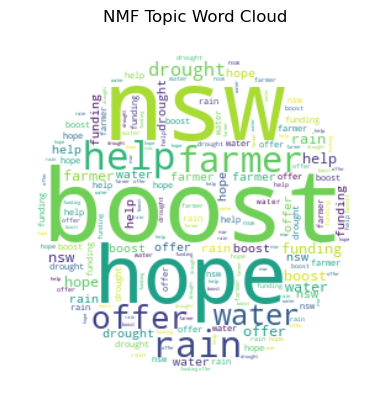

In [32]:
# Wordcloud visualization for NMF topics

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color='white', repeat = True, mask = mask)
for i in range(0,15):
    wc.generate(nmf_model.print_topic(i))

plt.axis("off")
plt.title("NMF Topic Word Cloud")
plt.imshow(wc, interpolation="bilinear")
plt.show()

### Evaluating the topic model performance
Coherance score can be measured for model performance evaluation. 

In [33]:
# Computing the Coherence Score
coherence_model_nmf = CoherenceModel(model=nmf_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score of the NMF Model: ', coherence_nmf)


Coherence Score of the NMF Model:  0.30804598427913826


**We can see that the coherance score of the LDA model is better than the coherance score of the NMF model.**
- The LDA model has a coherance score of 0.3978
- The NMF model has a coherance score of 0.3080
Clearly, LDA performs a better topic modeling where the topics are more understandable than the NMF model. 
